In [1]:
import yaml
import pandas as pd
import time
from backend.utils.data_preprocessor import DataPreprocessor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1h"

training_file_path: str = f"../data/indicators ({interval})/AAPL_indicators.csv"
validation_file_path: str = f"../data/indicators ({interval})/AMZN_indicators.csv"

start_time = time.time()

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)


In [2]:
training_preprocessor = DataPreprocessor(training_df)
validation_preprocessor = DataPreprocessor(validation_df)

X_train = training_preprocessor.target_data_batched
y_train = training_preprocessor.target_data_batched_labels

X_val = validation_preprocessor.target_data_batched
y_val = validation_preprocessor.target_data_batched_labels

print("Training Dataset shape:", training_df.shape)
print("Validation Dataset shape:", validation_df.shape)
print("Training sets shape:", X_train.shape, y_train.shape)
print("Validation sets shape:", X_val.shape, y_val.shape)
training_preprocessor.target_data

Training Dataset shape: (5000, 13)
Validation Dataset shape: (5000, 13)
Training sets shape: (4996, 3, 50) (4996,)
Validation sets shape: (4996, 3, 50) (4996,)


,open,high,low,close,volume,percent_b,macd,macd_signal,macd_hist,adx,...,adx-trend,previous ema,ema-change,ema-trend,previous rsi,rsi-change,rsi-trend,day_of_week,hour,target
datetime,,,,,,,,,,,,,,,,,,,,,
2021-02-25 12:30:00,122.25,122.62,120.76,122.12,22945491,0.08,-1.29,-1.25,-0.04,47.07,...,1,124.08,-0.39,0,33.97,-0.44,0,3,12,1
2021-02-25 13:30:00,122.11,123.43,121.76,123.15,14547371,0.29,-1.26,-1.25,-0.01,47.06,...,0,123.69,-0.11,0,33.53,6.32,1,3,13,0
2021-02-25 14:30:00,123.15,123.22,121.24,121.32,16414140,-0.00,-1.37,-1.27,-0.10,47.22,...,1,123.58,-0.45,0,39.85,-6.13,0,3,14,0
2021-02-25 15:30:00,121.32,122.03,120.54,121.01,19098194,0.01,-1.46,-1.31,-0.15,47.59,...,1,123.13,-0.43,0,33.72,-0.91,0,3,15,1
2021-02-26 09:30:00,122.84,123.95,121.31,121.50,35242461,0.13,-1.48,-1.35,-0.14,46.28,...,0,122.70,-0.24,0,32.81,2.97,1,4,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27 14:30:00,193.17,193.24,192.76,192.93,3255762,0.40,-0.63,-0.72,0.09,20.77,...,0,192.82,0.02,1,45.20,-1.81,0,2,14,1
2023-12-27 15:30:00,192.93,193.22,192.73,193.17,5694099,0.51,-0.56,-0.69,0.12,19.89,...,0,192.84,0.07,1,43.39,2.55,1,2,15,1
2023-12-28 09:30:00,194.58,194.65,193.73,194.25,8051603,0.91,-0.42,-0.63,0.21,19.70,...,0,192.91,0.27,1,45.94,9.66,1,3,9,0


In [3]:

X_train = X_train[:-training_preprocessor.trend_length]
y_train = y_train[:-training_preprocessor.trend_length]

X_val = X_val[:-validation_preprocessor.trend_length]
y_val = y_val[:-validation_preprocessor.trend_length]

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)

X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)
end_time = time.time()
loading_time = end_time - start_time
print("Loading time: ", loading_time)

Loading time:  40.00939583778381


In [5]:
from backend.models.stock_trend_lstm_model import StockTrendLSTMModel

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
epochs: int = config["data"]["epochs"]
batch_size: int = config["data"]["batch_size"]
my_model = StockTrendLSTMModel(input_shape, X_train_scaled, y_train, X_val_scaled, y_val, epochs, batch_size)
history = my_model.train()



Epoch 1/100


157/157 [==============================] - 3s 7ms/step - loss: 0.6975 - accuracy: 0.4991 - val_loss: 0.7234 - val_accuracy: 0.4819
Epoch 2/100
157/157 [==============================] - 1s 4ms/step - loss: 0.6960 - accuracy: 0.5009 - val_loss: 0.7158 - val_accuracy: 0.5013
Epoch 3/100
157/157 [==============================] - 1s 4ms/step - loss: 0.6952 - accuracy: 0.5105 - val_loss: 0.7091 - val_accuracy: 0.5001
Epoch 4/100
157/157 [==============================] - 1s 4ms/step - loss: 0.6949 - accuracy: 0.5181 - val_loss: 0.7087 - val_accuracy: 0.5027
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 0.6949 - accuracy: 0.5151 - val_loss: 0.7057 - val_accuracy: 0.5015
Epoch 6/100
157/157 [==============================] - 1s 4ms/step - loss: 0.6947 - accuracy: 0.5087 - val_loss: 0.7014 - val_accuracy: 0.5003
Epoch 7/100
157/157 [==============================] - 1s 4ms/step - loss: 0.6944 - accuracy: 0.5215 - val_loss: 0.6997 - val_accuracy: 0.

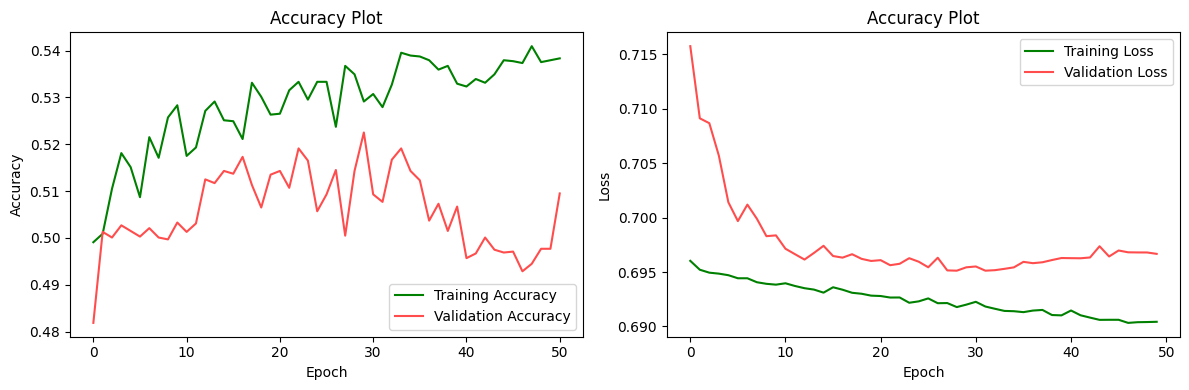

In [6]:
from backend.utils.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)